In [1]:
# basic imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from unyt import kW, minute, hour, day, MW, kg, lb, kWh, MWh
import sys
import time
import dill as pickle
import os
from glob import glob

# osier imports
from osier import CapacityExpansion
import osier.tech_library as lib
from osier.equations import total_cost, annual_emission, annual_co2
from osier import get_tech_names
from osier import technology_dataframe

# import megatonnes from unyt -- must be done after importing osier
from unyt import megatonnes

# pymoo imports
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.pcp import PCP
from functools import partial
from pymoo.termination.max_gen import MaximumGenerationTermination
from pymoo.indicators.hv import HV
from pymoo.mcdm.high_tradeoff import HighTradeoffPoints

from mycolorpy import colorlist as mcp
from time import sleep

# set the solver based on operating system -- assumes glpk or cbc is installed.
if "win32" in sys.platform:
    solver = 'glpk'
elif "linux" in sys.platform:
    solver = "appsi_highs"
else:
    solver = "appsi_highs"

print(f"Solver set: {solver}")

Solver set: appsi_highs


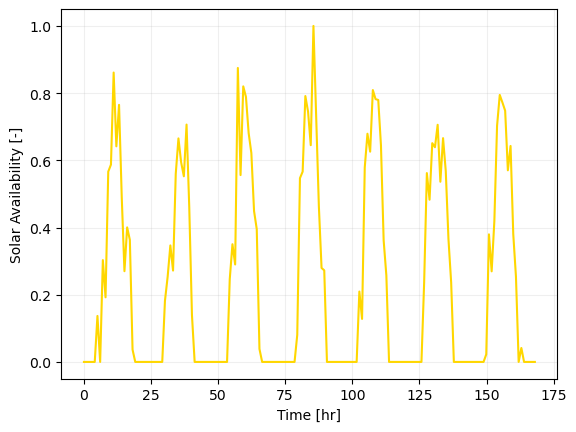

In [2]:
n_hours = 24  # hours per day
n_days = 7  # days to model
N = n_hours*n_days  # total number of time steps
phase_shift = np.pi/2  # horizontal shift [radians]
base_shift = 2  # vertical shift [units of demand]
hours = np.linspace(0,N,N)

solar_cp = (-np.sin((hours*np.pi/n_hours*2+phase_shift)))
# solar[solar<0] = 0

rng = np.random.default_rng(1234)

solar_cp += rng.normal(size=N)*15e-2
solar_cp[solar_cp<0] = 0

solar_cp = solar_cp/solar_cp.max()  # rescale


demand = np.ones(N)*1e3*MW
# print(demand)


# with plt.style.context("dark_background"):
#     plt.plot(hours, solar_cp, color='gold')
#     plt.ylabel('Solar Availability [-]')
#     plt.xlabel('Time [hr]')
#     plt.grid(alpha=0.2)
#     plt.show()


plt.plot(hours, solar_cp, color='gold')
plt.ylabel('Solar Availability [-]')
plt.xlabel('Time [hr]')
plt.grid(alpha=0.2)
plt.show()

In [3]:
peak_demand = 1e3*MW 
demand = np.ones(N)*peak_demand

In [4]:
natural_gas = lib.natural_gas
natural_gas_adv = lib.natural_gas_adv
nuclear_ap1000 = lib.nuclear
nuclear_smr = lib.nuclear_adv
solar = lib.solar
battery = lib.battery

In [5]:
emission_df = pd.read_html("https://www.eia.gov/tools/faqs/faq.php?id=74&t=11")[0].droplevel(1, axis=1).set_index('Unnamed: 0_level_0').iloc[:-1,:-2]
emission_df.columns = ['Total kWh', 'Total CO2 million mt', 'million short tons','lbs per kWh']
emission_df.index.name = ''
emission_df

,Total kWh,Total CO2 million mt,million short tons,lbs per kWh
,,,,
Coal,675115,709,781,2.31
Natural gas,1806063,790,871,0.96
Petroleum,16233,18,20,2.46
All other energy sources,4183271,1532,1688,0.81


In [6]:
eroi_df = pd.read_csv("../../../data/eroi_data.csv", index_col=0)
eroi_df

,EROIstd
Generation method,
Natural Gas (CCGT),89.0
Natural Gas (CCGT & CCS),12.4
"Solar PV (Mono-Si, SE-med)",2.5
Nuclear (83% centrifuge),69.6
Nuclear (100% centrifuge),96.2


In [7]:
final_techs = {'Utility PV - Class 1':'UtilityPV', 
    'NG 1-on-1 Combined Cycle (H-Frame)':"Natural Gas",
    'NG 1-on-1 Combined Cycle (H-Frame) 95% CCS':"Natural Gas CCS",
    'Nuclear - Large':"Nuclear",
    'Nuclear - Small':"Advanced Nuclear",        
    'Utility-Scale Battery Storage - 4Hr':"Battery",
    }

In [8]:
cost_df = pd.read_csv("../../../data/technology_costs.csv", index_col=['core_metric_parameter','display_name'])

In [9]:
# for a NG 1-on-1 H Frame design
natural_gas.co2_rate = (float(emission_df.at['Natural gas', 'lbs per kWh'])*lb/(kW*hour)).to(megatonnes/(MW*hour))
natural_gas.capital_cost = cost_df.at[('CAPEX','Natural Gas'), 'value'] / kW  / 1e6
natural_gas.om_cost_variable = cost_df.at[('Variable O&M','Natural Gas'), 'value'] / MWh / 1e6
natural_gas.om_cost_fixed = cost_df.at[('Fixed O&M','Natural Gas'), 'value'] / kW / 1e6
natural_gas.eroi = eroi_df.at['Natural Gas (CCGT)', 'EROIstd'] # from Walmsley et al.
# same design, with 95% CCS
natural_gas_adv.co2_rate = natural_gas.co2_rate * 0.05
natural_gas_adv.capital_cost = cost_df.at[('CAPEX','Natural Gas CCS'), 'value'] / kW / 1e6
natural_gas_adv.om_cost_variable = cost_df.at[('Variable O&M','Natural Gas CCS'), 'value'] / MWh / 1e6
natural_gas_adv.om_cost_fixed = cost_df.at[('Fixed O&M','Natural Gas CCS'), 'value'] / kW / 1e6
natural_gas_adv.eroi = eroi_df.at['Natural Gas (CCGT & CCS)', 'EROIstd'] # from Walmsley et al.

In [10]:
# utility scale solar, with good insolation, middling estimate
solar.capital_cost = cost_df.at[('CAPEX','UtilityPV'), 'value']/kW / 1e6
solar.eroi = eroi_df.at['Solar PV (Mono-Si, SE-med)', 'EROIstd'] # from Walmsley et al. 2018
solar.om_cost_fixed = cost_df.at[('Fixed O&M','UtilityPV'), 'value']/kW / 1e6
solar.co2_rate = 0*(megatonnes/(MW*hour))
solar.fuel_cost = 0/(MW*hour)

In [11]:
battery.capital_cost = cost_df.at[('CAPEX','Battery'), 'value'] / kW / 1e6
battery.om_cost_fixed = cost_df.at[('Fixed O&M','Natural Gas'), 'value']/ kW / 1e6
battery.eroi = 10  # actually an 'ESOI,' from Barnhart and Benson 2013
battery.co2_rate = 0*(megatonnes/(MW*hour))
battery.fuel_cost = 0/(MW*hour)


In [12]:
nuclear_ap1000.capital_cost = cost_df.at[('CAPEX','Nuclear'), 'value'] / kW / 1e6
nuclear_ap1000.om_cost_fixed = cost_df.at[('Fixed O&M','Nuclear'), 'value'] / kW / 1e6
nuclear_ap1000.om_cost_variable = cost_df.at[('Variable O&M','Nuclear'), 'value']/ MWh / 1e6
nuclear_ap1000.eroi = eroi_df.at['Nuclear (100% centrifuge)', 'EROIstd']
nuclear_ap1000.co2_rate = 0*(megatonnes/(MW*hour))

nuclear_smr.capital_cost = cost_df.at[('CAPEX','Advanced Nuclear'), 'value'] / kW / 1e6
nuclear_smr.om_cost_fixed = cost_df.at[('Fixed O&M','Advanced Nuclear'), 'value']/ kW / 1e6
nuclear_smr.om_cost_variable = cost_df.at[('Variable O&M','Advanced Nuclear'), 'value']/ MWh / 1e6
nuclear_smr.eroi = eroi_df.at['Nuclear (100% centrifuge)', 'EROIstd']
nuclear_smr.co2_rate = 0*(megatonnes/(MW*hour))

In [13]:
tech_list = [natural_gas, natural_gas_adv, solar, battery, nuclear_ap1000, nuclear_smr]

In [14]:
tech_data_df = technology_dataframe(tech_list, cast_to_string=True).T.iloc[[13,14,15,16, 17, 21, ],:]

In [15]:
def eroi_objective(technology_list, solved_dispatch_model):
    """
    Calculate the objective to ``maximize'' the Energy Return on Investment (EROI)
    by minimizing its inverse.
    """
    obj_value = np.array([t.capacity.to_value() / t.eroi for t in technology_list]).sum()
    return obj_value

In [17]:
problem = CapacityExpansion(technology_list=tech_list,
                            demand=demand,
                            solar=solar_cp,
                            upper_bound = 1 / solar.capacity_credit,
                            objectives = [total_cost, 
                                         partial(annual_emission, emission='co2_rate'),
                                         eroi_objective],
                            solver=solver,
                            model_engine='logical'
                            )

In [40]:
checkpoint_list = glob("checkpoint_logical_*.pkl")
checkpoint_list.sort()
# checkpoint_list = []
if len(checkpoint_list) > 0:
    with open(checkpoint_list[-1], 'rb') as f:
        algorithm = pickle.load(f)
        algorithm.termination = MaximumGenerationTermination(200)
        print(f"Loaded {checkpoint_list[-1]}:", algorithm)
else:
    print("No checkpoints found. Starting new run.")
    algorithm = NSGA2(pop_size=100)
    algorithm.termination = MaximumGenerationTermination(120)
    
try:
    res = minimize(problem,
                    algorithm,
                    seed=1,
                    copy_algorithm=False,
                    save_history=True,
                    verbose=True)
    # save results
    print('Saving simulation results')
    with open("datacenter_results_EROI_Logical.pkl", "wb") as file:
        pickle.dump(res, file)
    # save final checkpoint
    timestr = time.strftime("%Y%m%d-%H%M%S")
    checkpoint_name = f"checkpoint_logical_{timestr}.pkl"
    print(f"Saving final simulation checkpoint to {checkpoint_name}")
    with open(checkpoint_name, "wb") as f:
        pickle.dump(algorithm, f)
except KeyboardInterrupt:
    # save checkpoint on early termination
    timestr = time.strftime("%Y%m%d-%H%M%S")
    checkpoint_name = f"checkpoint_logical_{timestr}.pkl"
    print(f"Simulation stopped. Saving checkpoint to {checkpoint_name}")
    with open(checkpoint_name, "wb") as f:
        pickle.dump(algorithm, f)

Loaded checkpoint_logical_20250701-165318.pkl: <pymoo.algorithms.moo.nsga2.NSGA2 object at 0x76f7ae7e0>
   121 |    12100 |    100 |  0.0017669700 |             f
   122 |    12200 |    100 |  0.0074967143 |             f
   123 |    12300 |    100 |  0.0049210715 |             f
   124 |    12400 |    100 |  0.0030763358 |             f
   125 |    12500 |    100 |  0.0038122304 |             f
   126 |    12600 |    100 |  0.0024772728 |             f
   127 |    12700 |    100 |  0.0056686088 |             f
   128 |    12800 |    100 |  0.0038756317 |         ideal
   129 |    12900 |    100 |  0.0021280180 |             f
   130 |    13000 |    100 |  0.0038259167 |         ideal
   131 |    13100 |    100 |  0.0039500197 |             f
   132 |    13200 |    100 |  0.0040863300 |             f
   133 |    13300 |    100 |  0.0019122383 |             f
   134 |    13400 |    100 |  0.0155706291 |         nadir
   135 |    13500 |    100 |  0.0044390470 |             f
   136 |   

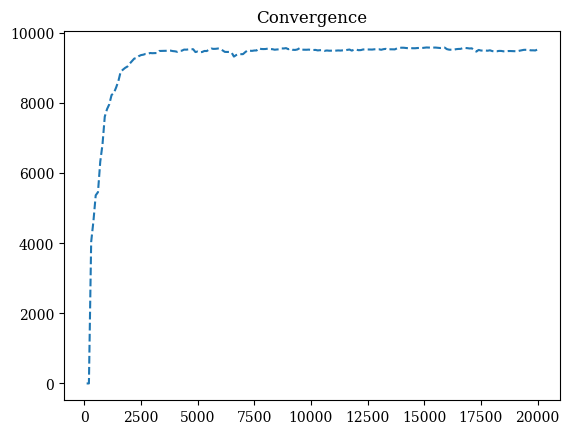

In [41]:
ref_point = np.max(np.array([opt.F for opt in res.history[0].opt]), axis=0)

ind = HV(ref_point=ref_point)

performance_list = []
for pop in res.history:
    pop_pf = np.array([e.F for e in pop.opt])
    performance_list.append(ind(pop_pf))

n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])

plt.title("Convergence")
plt.plot(n_evals, performance_list, "--")
# plt.yscale("log")
plt.show()

In [ ]:
timestr = time.strftime("%Y%m%d-%H%M%S")
checkpoint_name = f"checkpoint_{timestr}.pkl"
with open(checkpoint_name, "wb") as f:
    pickle.dump(algorithm, f)

with open(checkpoint_name, 'rb') as f:
    checkpoint = pickle.load(f)
    print("Loaded Checkpoint:", checkpoint)

Loaded Checkpoint: <pymoo.algorithms.moo.nsga2.NSGA2 object at 0x341b0c770>


In [22]:
checkpoint.termination = MaximumGenerationTermination(80)

In [23]:
res = minimize(problem,
               checkpoint,
               seed=1,
               copy_algorithm=False,
               verbose=True)

    11 |     1100 |     31 |  0.0740951016 |         ideal
    12 |     1200 |     31 |  0.0602957121 |         ideal
    13 |     1300 |     39 |  0.0529026950 |         ideal
    14 |     1400 |     43 |  0.0268447497 |             f
    15 |     1500 |     39 |  0.0277140011 |             f
    16 |     1600 |     46 |  0.0327580510 |         ideal
    17 |     1700 |     59 |  0.0281879547 |         ideal
    18 |     1800 |     54 |  1.3488512376 |         nadir
    19 |     1900 |     62 |  0.0102131710 |             f
    20 |     2000 |     75 |  0.0131456556 |             f
    21 |     2100 |     91 |  0.0031222510 |         ideal
    22 |     2200 |     94 |  0.0032951957 |         ideal
    23 |     2300 |     90 |  0.0385119157 |         ideal
    24 |     2400 |     96 |  0.0465145267 |         ideal
    25 |     2500 |    100 |  0.0168106896 |         ideal
    26 |     2600 |    100 |  0.0069921858 |             f
    27 |     2700 |    100 |  0.0111966776 |         nad

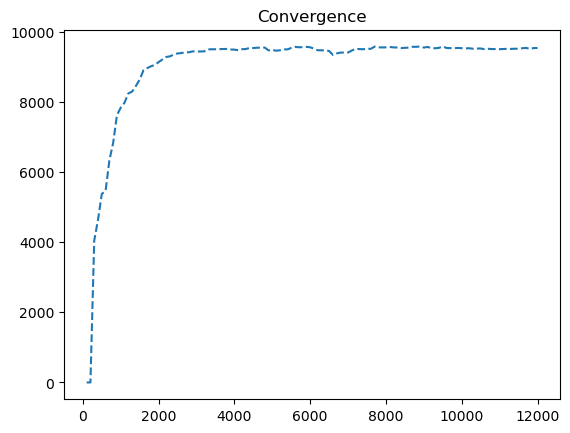

In [20]:

performance_list = []
for pop in res.history:
    pop_pf = np.array([e.F for e in pop.opt])
    performance_list.append(ind(pop_pf))

n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])

plt.title("Convergence")
plt.plot(n_evals, performance_list, "--")
# plt.yscale("log")
plt.show()

In [26]:
with open("datacenter_results_EROI80.pkl", "wb") as file:
    pickle.dump(res, file)

In [42]:
timestr = time.strftime("%Y%m%d-%H%M%S")
checkpoint_name = f"checkpoint_{timestr}.pkl"
with open(checkpoint_name, "wb") as f:
    pickle.dump(checkpoint, f)

with open(checkpoint_name, 'rb') as f:
    checkpoint = pickle.load(f)
    print("Loaded Checkpoint:", checkpoint)

Loaded Checkpoint: <pymoo.algorithms.moo.nsga2.NSGA2 object at 0x3879d57f0>


In [43]:
checkpoint.termination = MaximumGenerationTermination(120)
res = minimize(problem,
               checkpoint,
               seed=1,
               copy_algorithm=False,
               verbose=True)
timestr = time.strftime("%Y%m%d-%H%M%S")
checkpoint_name = f"checkpoint_{timestr}.pkl"
with open(checkpoint_name, "wb") as f:
    pickle.dump(checkpoint, f)
with open("datacenter_results_EROI120.pkl", "wb") as file:
    pickle.dump(res, file)

    81 |     8100 |    100 |  0.0029290521 |         nadir
    82 |     8200 |    100 |  0.0032879832 |         nadir
    83 |     8300 |    100 |  0.0024944851 |             f
    84 |     8400 |    100 |  0.0086888646 |             f
    85 |     8500 |    100 |  0.0188972970 |         nadir
    86 |     8600 |    100 |  0.0061161695 |             f
    87 |     8700 |    100 |  0.0018409395 |             f
    88 |     8800 |    100 |  0.0300307670 |         nadir
    89 |     8900 |    100 |  0.0084888872 |             f
    90 |     9000 |    100 |  0.0040799667 |             f
    91 |     9100 |    100 |  0.0030379186 |             f
    92 |     9200 |    100 |  0.0042021878 |             f
    93 |     9300 |    100 |  0.0007769874 |             f
    94 |     9400 |    100 |  0.0038157884 |         ideal
    95 |     9500 |    100 |  0.0187478629 |         nadir
    96 |     9600 |    100 |  0.1741985898 |         nadir
    97 |     9700 |    100 |  0.0036032634 |            

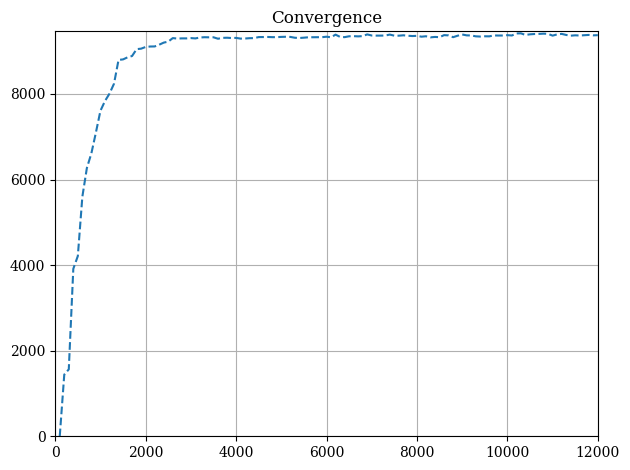

In [45]:
performance_list = []
for pop in res.history:
    pop_pf = np.array([e.F for e in pop.opt])
    performance_list.append(ind(pop_pf))
n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])

plt.title("Convergence")
plt.plot(n_evals, performance_list, "--")
# plt.yscale("log")
plt.grid()
plt.ylim(min(performance_list), max(performance_list)*1.005)
plt.xlim(0, max(n_evals))
# plt.xscale('log')
plt.tight_layout()
plt.show()

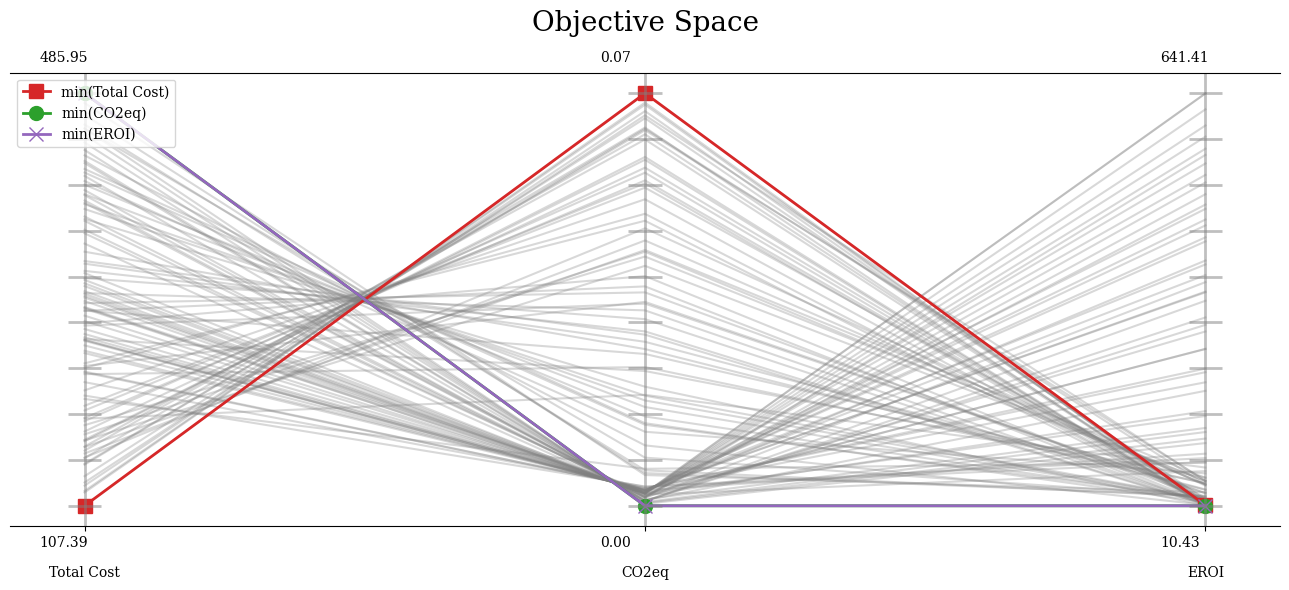

In [42]:
obj_labels=['Total Cost', 'CO2eq', 'EROI']
obj_markers=['s','o','x']
obj_colors=['tab:red','tab:green','tab:purple']
# with plt.style.context('dark_background'):
plot = PCP(title=("Objective Space", {'pad': 30, 'fontsize':20}),
        n_ticks=10,
        legend=(True, {'loc': "upper left"}),
        labels=obj_labels,
        figsize=(13,6),
        )

plot.set_axis_style(color="grey", alpha=0.5)
plot.tight_layout = True
plot.add(res.F, color="grey", alpha=0.3)

for i, label in enumerate(obj_labels):
    min_idx = np.where(res.F[:,i]==min(res.F[:,i]))[0][0]
    # if i == 2:
    #     continue
    plot.add(res.F[min_idx], linewidth=2, label=f"min({label})", marker=obj_markers[i], markersize=10, color=obj_colors[i])
    # plot.add(res.F[3], linewidth=5, color="tab:green", label=r"Least CO$_2$")
    # plot.add(res.F[6], linewidth=5, color="tab:blue", label="Least Cost")
plot.show()
plt.show()

In [43]:
arr = res.F[:,2]
n = 3

# Get the indices of the n smallest values
indices_of_smallest_n = np.argpartition(arr, n)[:n]

# Use these indices to get the values from the original array
smallest_n_values_from_indices = arr[indices_of_smallest_n]

print(f"The indices of the {n} smallest values are: {indices_of_smallest_n}")
print(f"The {n} smallest values are: {smallest_n_values_from_indices}")

The indices of the 3 smallest values are: [ 0 23 83]
The 3 smallest values are: [10.42698964 10.96601011 11.2697487 ]


In [44]:
res.exec_time/60

103.76102372010548

getting values for Total Cost
indices of smallest Total Cost are: [ 1 65 38 93 81 47 95 85 98 20]
getting values for CO2eq
indices of smallest CO2eq are: [52  0 35  3 45 32  9  5 56 48]
getting values for EROI
indices of smallest EROI are: [ 0 37 93 23 83  1 66 64 38  6]


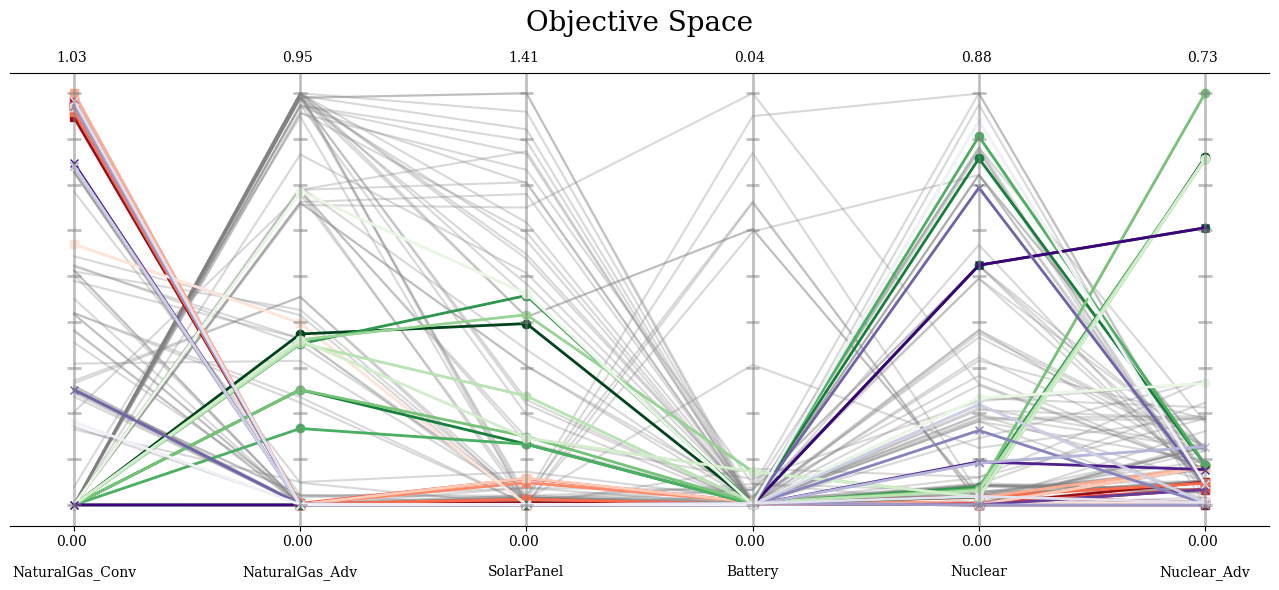

In [45]:
# fig, ax = plt.subplots()
obj_labels=['Total Cost', 'CO2eq', 'EROI']
tech_labels = get_tech_names(tech_list)
plot = PCP(title=(f"Objective Space", {'pad': 30, 'fontsize':20}),
           n_ticks=10,
           legend=(False, {'loc': "upper left"}),
           labels=tech_labels,
           figsize=(13,6),
           )

plot.set_axis_style(color="grey", alpha=0.5)
plot.tight_layout = True
plot.add(res.X, color="grey", alpha=0.3)


obj_colors = {
              'Total Cost':'Reds_r',
              'CO2eq':'Greens_r',
              'EROI':'Purples_r',
              }
markers = ['s','o','x']
# objective = 'lifecycle_co2_rate'
# objective = 'total_cost'
n = 10
for i, (obj, colors) in enumerate(obj_colors.items()):
    print(f"getting values for {obj}")
    # get the n_smallest values
    F_i = res.F[:,i]
    idx_smallest = np.argpartition(F_i, n)[:n]

    print(f"indices of smallest {obj} are: {idx_smallest}")
    # generate color map
    cmap = colors
    color=mcp.gen_color(cmap=cmap,n=n+1)

    X_i = res.X[idx_smallest]
    for j, x in enumerate(X_i):
    #     print(subset_df.loc[i, objective], color[i],d)
        plot.add(x, linewidth=2, color=color[j], marker=markers[i])

plot.show()

In [87]:
[label.replace("_","") for label in tech_labels]

['NaturalGasConv',
 'NaturalGasAdv',
 'SolarPanel',
 'Battery',
 'Nuclear',
 'NuclearAdv']

In [33]:
res.X[0]

array([1.00634451e+00, 5.51117564e-05, 3.46762036e-03, 5.02950919e-05,
       4.07786300e-03, 5.66664342e-03])

In [34]:
min_idx

1

In [46]:
# obj_labels=['Total Cost', 'CO2eq', 'EROI']
tech_labels = get_tech_names(tech_list)
# with plt.style.context('dark_background'):
plot = PCP(title=("Design Space", {'pad': 30, 'fontsize':20}),
        n_ticks=10,
        legend=(True, {'loc': "upper left"}),
        labels=tech_labels,
        figsize=(13,6),
        )

plot.set_axis_style(color="grey", alpha=0.5)
plot.tight_layout = True
plot.add(res.X, color="grey", alpha=0.3)

for i, label in enumerate(obj_labels):
    min_idx = np.where(res.F[:,i]==min(res.F[:,i]))[0][0]
    # if i == 2:
    #     continue
    plot.add(res.X[min_idx], linewidth=2, label=f"min({label})", marker=obj_markers[i], markersize=10, color=obj_colors[i])
    # plot.add(res.F[3], linewidth=5, color="tab:green", label=r"Least CO$_2$")
    # plot.add(res.F[6], linewidth=5, color="tab:blue", label="Least Cost")
plot.show()
#     plt.show()

KeyError: 0

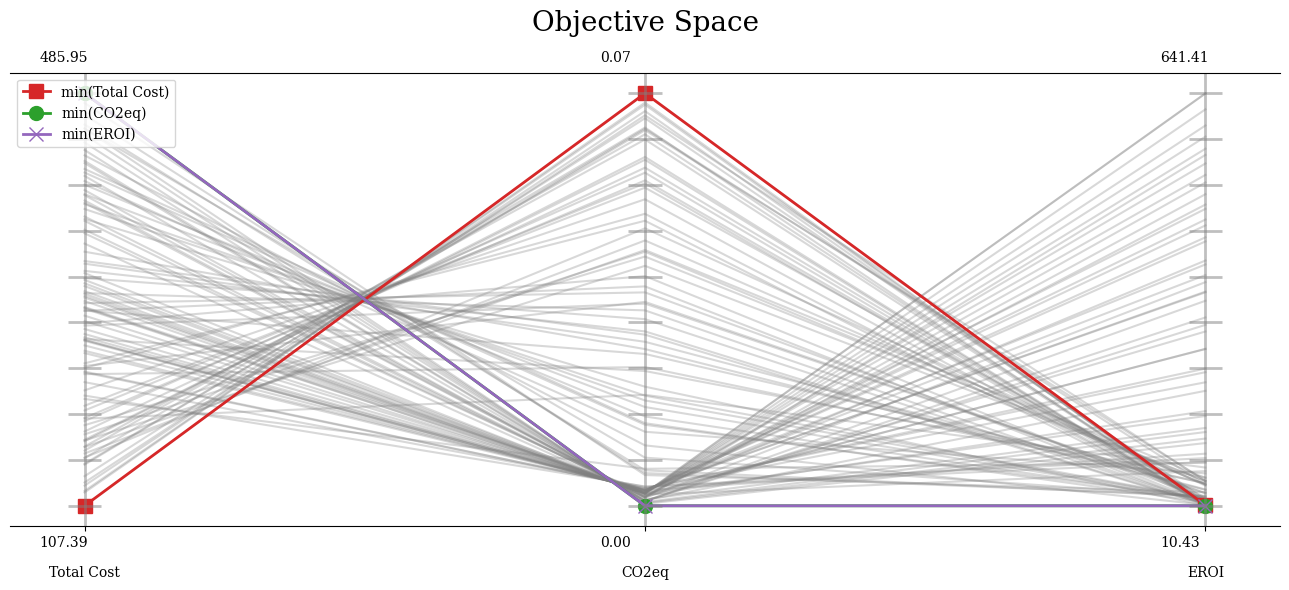

In [47]:
obj_labels=['Total Cost', 'CO2eq', 'EROI']
obj_markers=['s','o','x']
obj_colors=['tab:red','tab:green','tab:purple']
# with plt.style.context('dark_background'):
plot = PCP(title=("Objective Space", {'pad': 30, 'fontsize':20}),
        n_ticks=10,
        legend=(True, {'loc': "upper left"}),
        labels=obj_labels,
        figsize=(13,6),
        )

plot.set_axis_style(color="grey", alpha=0.5)
plot.tight_layout = True
plot.add(res.F, color="grey", alpha=0.3)

for i, label in enumerate(obj_labels):
    min_idx = np.where(res.F[:,i]==min(res.F[:,i]))[0][0]
    # if i == 2:
    #     continue
    plot.add(res.F[min_idx], linewidth=2, label=f"min({label})", marker=obj_markers[i], markersize=10, color=obj_colors[i])
    # plot.add(res.F[3], linewidth=5, color="tab:green", label=r"Least CO$_2$")
    # plot.add(res.F[6], linewidth=5, color="tab:blue", label="Least Cost")
plot.show()
plt.show()

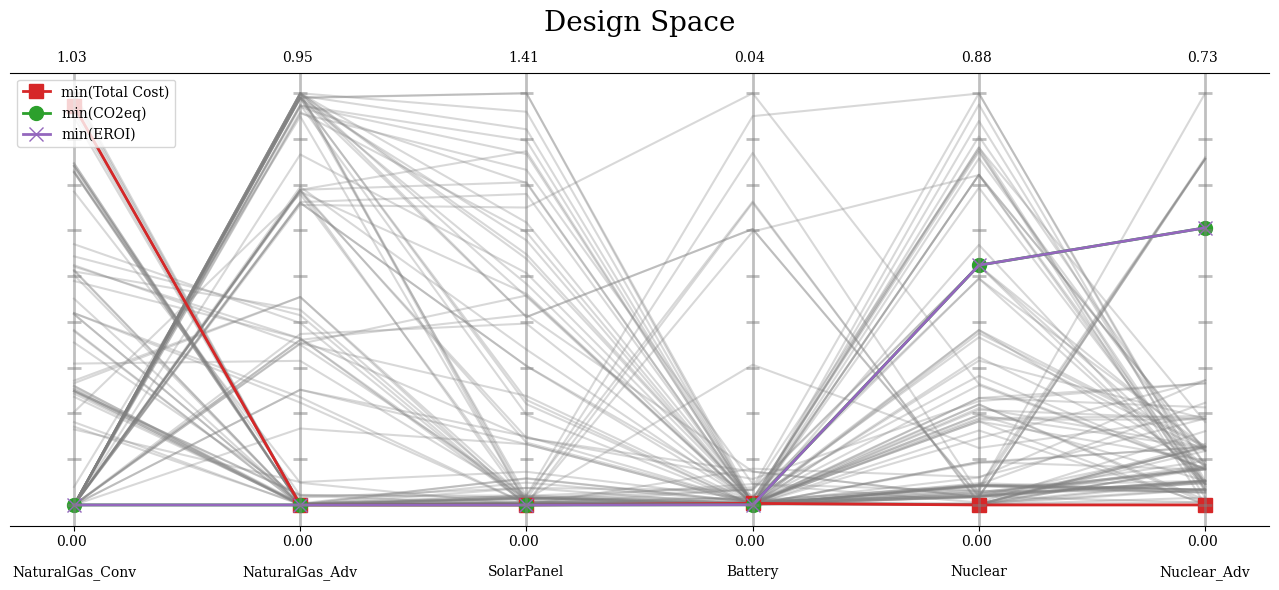

In [48]:
# obj_labels=['Total Cost', 'CO2eq', 'EROI']
tech_labels = get_tech_names(tech_list)
# with plt.style.context('dark_background'):
plot = PCP(title=("Design Space", {'pad': 30, 'fontsize':20}),
        n_ticks=10,
        legend=(True, {'loc': "upper left"}),
        labels=tech_labels,
        figsize=(13,6),
        )

plot.set_axis_style(color="grey", alpha=0.5)
plot.tight_layout = True
plot.add(res.X, color="grey", alpha=0.3)

for i, label in enumerate(obj_labels):
    min_idx = np.where(res.F[:,i]==min(res.F[:,i]))[0][0]
    # if i == 2:
    #     continue
    plot.add(res.X[min_idx], linewidth=2, label=f"min({label})", marker=obj_markers[i], markersize=10, color=obj_colors[i])
    # plot.add(res.F[3], linewidth=5, color="tab:green", label=r"Least CO$_2$")
    # plot.add(res.F[6], linewidth=5, color="tab:blue", label="Least Cost")
plot.show()
#     plt.show()

In [29]:
dm = HighTradeoffPoints()
I = dm(res.F)

In [30]:
I

array([0])

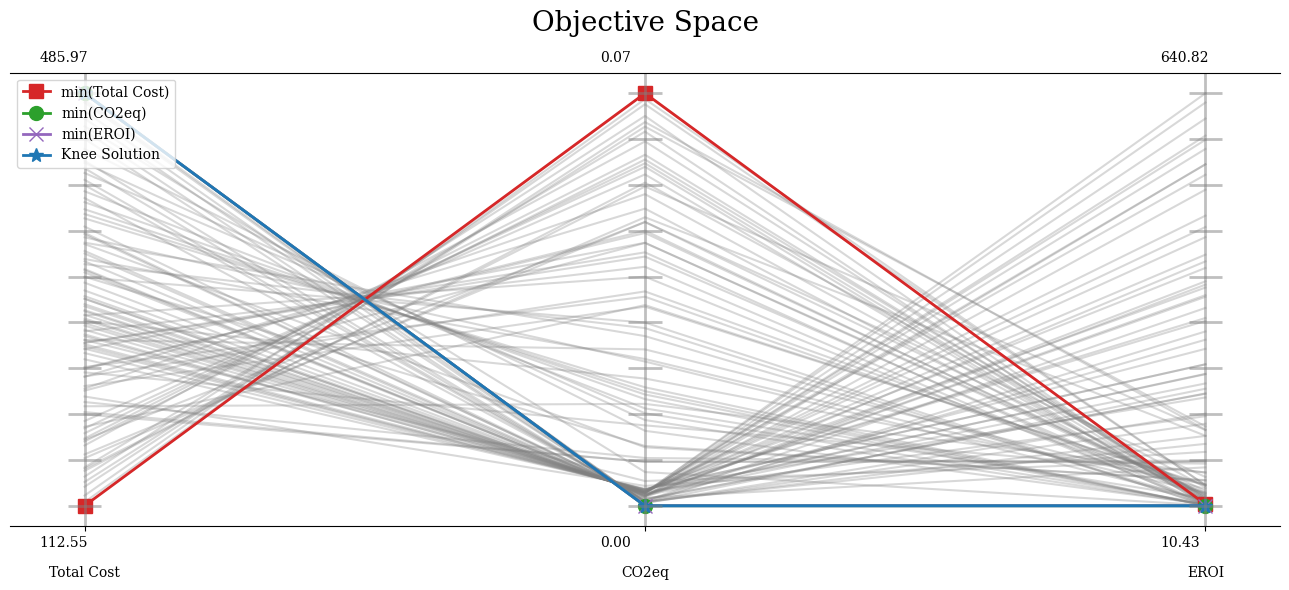

In [31]:
obj_labels=['Total Cost', 'CO2eq', 'EROI']
obj_markers=['s','o','x']
obj_colors=['tab:red','tab:green','tab:purple']
# with plt.style.context('dark_background'):
plot = PCP(title=("Objective Space", {'pad': 30, 'fontsize':20}),
        n_ticks=10,
        legend=(True, {'loc': "upper left"}),
        labels=obj_labels,
        figsize=(13,6),
        )

plot.set_axis_style(color="grey", alpha=0.5)
plot.tight_layout = True
plot.add(res.F, color="grey", alpha=0.3)

for i, label in enumerate(obj_labels):
    min_idx = np.where(res.F[:,i]==min(res.F[:,i]))[0][0]
    # if i == 2:
    #     continue
    plot.add(res.F[min_idx], linewidth=2, label=f"min({label})", marker=obj_markers[i], markersize=10, color=obj_colors[i])
    # plot.add(res.F[3], linewidth=5, color="tab:green", label=r"Least CO$_2$")
    # plot.add(res.F[6], linewidth=5, color="tab:blue", label="Least Cost")

plot.add(res.F[min_idx], linewidth=2, label=f"Knee Solution", marker="*", markersize=10, color="tab:blue")

plot.show()
plt.show()

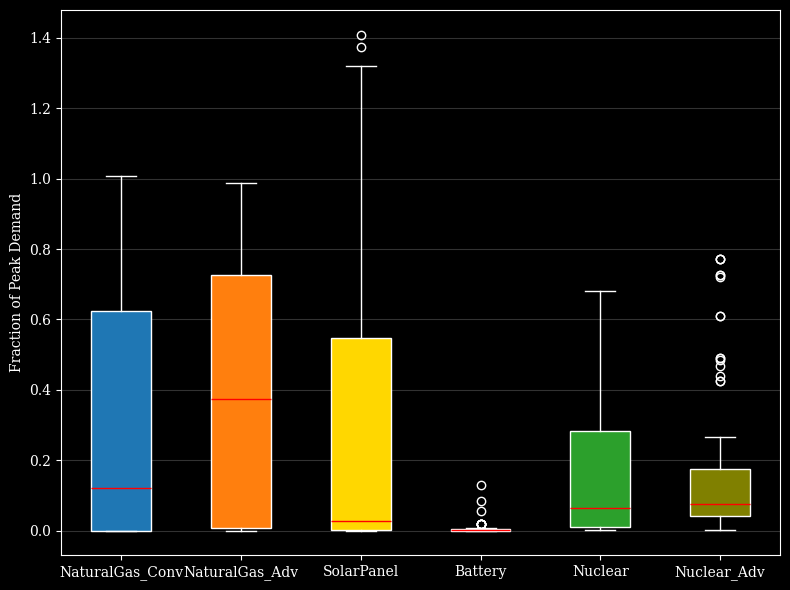

In [35]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(8,6))

    bplot = ax.boxplot(res.X,
                       patch_artist=True,
                       tick_labels=get_tech_names(problem.technology_list))
    ax.set_ylabel("Fraction of Peak Demand")

    # fill with colors
    colors = ['tab:blue', 'tab:orange', 'gold','gray','tab:green','olive']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    for median in bplot['medians']:
        median.set_color('red')

    ax.yaxis.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

In [ ]:
technology_dataframe(tech_list, cast_to_string=True).T.reset_index()#.loc[[13,14,15,16, 17, 22, ],:]

technology_name,index,NaturalGas_Conv,NaturalGas_Adv,SolarPanel,Battery,Nuclear,Nuclear_Adv
0,technology_category,thermal,thermal,base,base,thermal,thermal
1,technology_type,production,production,production,storage,production,production
2,dispatchable,True,True,False,True,True,True
3,renewable,False,False,True,False,False,False
4,fuel_type,None,None,solar,None,None,None
5,ramp_up_rate (1/hr),1,1,NaN,NaN,0,0.25
6,ramp_down_rate (1/hr),1,1,NaN,NaN,0,0.25
7,lifetime,25,25,25,25,25,25
8,capacity (MW),8.38e+03,0,2.81e+03,815,1.86e+04,0
9,power_level (MW),8.38e+03,0,2.81e+03,815,1.86e+04,0


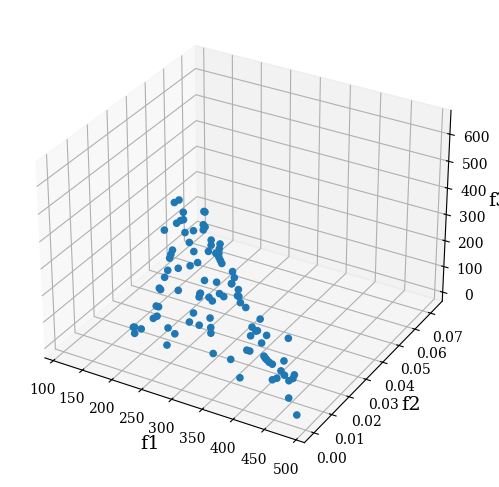

In [39]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
# ax.plot_trisurf(*zip(*res.F), alpha=1)
ax.scatter3D(*zip(*res.F), alpha=1)
# ax.view_init(azim=0, elev=90)
# ax.view_init(azim=0, elev= 0)
# ax.view_init(azim=90, elev=0)
ax.set_xlabel('f1', fontsize=14, labelpad=2)
ax.set_ylabel('f2', fontsize=14, labelpad=2)
ax.set_zlabel('f3', fontsize=14, labelpad=2)
# plt.tight_layout()
plt.show()

In [89]:
with open("../../../../2023-osier-simulation-results/2023-05-30-NOBJ4-USNGA3-results.pkl", "rb") as file:
    old_results = pickle.load(file)

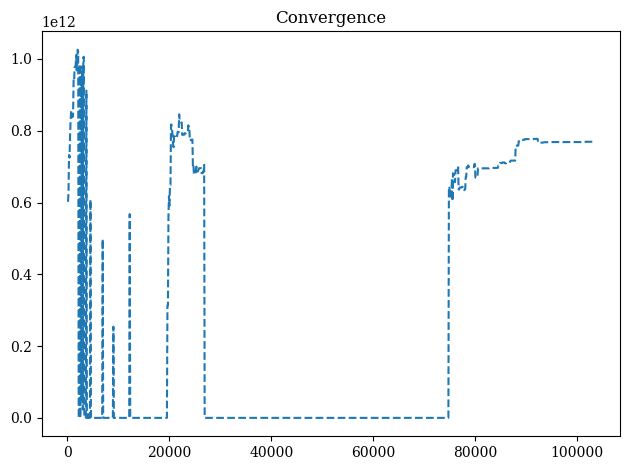

In [100]:
ref_point = np.max(np.array([opt.F for opt in old_results.history[0].opt]), axis=0)

ind = HV(ref_point=ref_point)


performance_list = []
for pop in old_results.history:
    pop_pf = np.array([e.F for e in pop.opt])
    performance_list.append(ind(pop_pf))


n_evals = np.array([e.evaluator.n_eval for e in old_results.history])

plt.title("Convergence")
plt.plot(n_evals, performance_list, "--")
# plt.yscale("log")
# plt.xlim(0,5000)
# plt.xlim(70000,105000)
plt.tight_layout()
plt.show()

In [103]:
solar_cp.sum()/N

0.238621951592595

In [163]:
with open("../../checkpoint_20250622-182524.pkl", "rb") as f:
    checkpoint_run = pickle.load(f)

In [167]:
res.history[0]

In [170]:
checkpoint_run.n_gen

207

In [174]:
res = checkpoint_run.history[205]

In [168]:
checkpoint_run.history[0].opt

Population([<pymoo.core.individual.Individual object at 0x34d1cc230>,
           dtype=object)